In [1]:
import tensorflow as tf
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL

%matplotlib inline

In [2]:
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [3]:
shape = 100, 100
num_channels = 1
vec_size = 64

## Data utils

In [4]:
def load_dir(path, shape=[400, 400], one_channel=True):
    data = []
    for i in os.listdir(path):
        try:
            img = np.array(Image.open(os.path.join(path, i)).resize(shape))
            
            if len(img.shape) != 3:
                img = np.stack((img,)*3, -1)
            if img.shape[-1] != 3:
                continue
            
            if one_channel:
                img = img[:, :, 0]
                
            data.append(img)
        except:
            1
    return np.array(data)

def load_dirs(path, shape=[400, 400]):
    data = []

    for dir in os.listdir(path):
        if os.path.isdir(os.path.join(path, dir)):
            data.extend(load_dir(os.path.join(path, dir)))

    data = np.array(data)
    
    return data

data = []
root_dir = 'data/'

for dir in os.listdir(root_dir):
    if os.path.isdir(os.path.join(root_dir, dir)):
        data.extend(load_dir(os.path.join(root_dir, dir), shape=shape))
    
data = np.array(data)
#data = np.array(list(map(lambda x: x[:, :, 0], data)))

In [5]:
data.shape

(18724, 100, 100)

In [6]:
data = data.reshape([-1, shape[0], shape[1], 1])

In [7]:
data.shape

(18724, 100, 100, 1)

## VAE

In [8]:
x = tf.placeholder(dtype=tf.float32, shape=[None, shape[0], shape[1], num_channels])

### Encoder

In [9]:
def encoder(x):
    # Convolutions 

    conv = tf.layers.conv2d(x, 16, 4, activation=tf.nn.relu)
    pool = tf.layers.max_pooling2d(conv, 6, 1)

    conv = tf.layers.conv2d(pool, 32, 4, activation=tf.nn.relu)
    pool = tf.layers.max_pooling2d(conv, 8, 2)

    # Denses

    pool_shape = pool.shape

    flat_pool = tf.reshape(pool, [-1, (pool_shape[1]*pool_shape[2]*pool_shape[3]).value])

    dense = tf.layers.dense(flat_pool, 256, activation=tf.nn.relu)

    # Output

    gausian_params = tf.layers.dense(dense, vec_size*2)

    return gausian_params[:, :vec_size], 1e-16 + tf.nn.softplus(gausian_params[:, vec_size:])

In [10]:
with tf.variable_scope('encoder'):
    means, std_devs = encoder(x)

z = means + std_devs * tf.random_uniform(tf.shape(means), 0, 1, dtype=tf.float32)

## Decoder

In [11]:
input_z = tf.placeholder(tf.float32, shape=[None, vec_size])

In [12]:
with tf.variable_scope('decoder'):
    
    decoder_weights = {
        'first_dense': tf.Variable(glorot_init(shape=[vec_size, vec_size*2]), dtype=tf.float32, name='first_dense_weights'),
        'second_dense': tf.Variable(glorot_init(shape=[vec_size*2, vec_size*3]), dtype=tf.float32, name='second_dense_weights'),
        'third_dense': tf.Variable(glorot_init(shape=[vec_size*3, vec_size*4]), dtype=tf.float32, name='third_dense_weights'),
        'output': tf.Variable(glorot_init(shape=[vec_size*4, shape[0]*shape[1]*num_channels]), dtype=tf.float32, name='output_weights'),
    }

    decoder_biases = {
        'first_dense': tf.Variable(tf.zeros(vec_size*2), dtype=tf.float32, name='first_dense_bias'),
        'second_dense': tf.Variable(tf.zeros(vec_size*3), dtype=tf.float32, name='second_dense_bias'),
        'third_dense': tf.Variable(tf.zeros(vec_size*4), dtype=tf.float32, name='third_dense_bias'),
        'output': tf.Variable(tf.zeros(shape[0]*shape[1]*num_channels), name='output_bias')
    }

In [13]:
def decoder(z):
    
    dense = tf.nn.relu(tf.matmul(z, decoder_weights['first_dense']) + decoder_biases['first_dense'])
    
    dense = tf.nn.relu(tf.matmul(dense, decoder_weights['second_dense']) + decoder_biases['second_dense'])
    
    dense = tf.nn.relu(tf.matmul(dense, decoder_weights['third_dense']) + decoder_biases['third_dense'])
    
    raw_output = tf.matmul(dense, decoder_weights['output']) + decoder_biases['output']
    
    raw_output = tf.clip_by_value(raw_output, 0, 255)
    
    return tf.reshape(raw_output, shape=[tf.shape(raw_output)[0], shape[0], shape[1], num_channels])

In [14]:
y = decoder(z)
output_decoder = decoder(input_z)

## Train Utils

In [15]:
marginal_likelihood = tf.reduce_sum(np.power(x - y, 2))
KL_divergence = 0.5 * tf.reduce_sum(tf.square(means) + tf.square(std_devs) - tf.log(1e-8 + tf.square(std_devs)) - 1, 1)

marginal_likelihood = tf.reduce_mean(marginal_likelihood)
KL_divergence = tf.reduce_mean(KL_divergence)

loss = marginal_likelihood + KL_divergence

In [16]:
optim = tf.train.AdamOptimizer().minimize(loss)

## Training

In [17]:
sess = tf.InteractiveSession()

In [18]:
sess.run(tf.global_variables_initializer())

In [19]:
save = tf.train.Saver()

In [19]:
save.restore(sess, 'weights/VAE_notMNIST_BW_63')

In [20]:
def display_encoded(ids, one_channel=True):
    shape = data.shape[1],data.shape[2]
    
    f, axar = plt.subplots(len(ids), 2, figsize=(8, 6))
    
    for e, i in enumerate(ids):
        axar[e, 0].grid(False); axar[e, 1].grid(False)
        
        if one_channel:
            pic = data[i].reshape(shape)
        else:
            pic = data[i]
            
        axar[e, 0].imshow(PIL.Image.fromarray(pic), cmap='Greys',)
        generated = sess.run(y, feed_dict={x: np.array([data[i]], dtype=np.float32)})
        
        if one_channel:
            gen_pic = generated[0].astype(np.uint8).reshape(shape)
        else:
            gen_pic = generated[0].astype(np.uint8)
            
        axar[e, 1].imshow(PIL.Image.fromarray(gen_pic), cmap='Greys')

In [28]:
file_name = 'new_weights/VAE_notMNIST_'

batchsize = 100
epochs = 500

for e in range(epochs):
    np.random.shuffle(data)
    print('Epoch: ', e)
    losses = []
    for i in range(0, len(data)-batchsize, batchsize):
        _, l = sess.run([optim, loss], feed_dict={x: data[i:i+batchsize]})
        losses.append(l)
        if i % 100 == 0:
            print('Loss: ', np.mean(losses))
            
    save.save(sess, file_name+str(e))
    print('Epoch loss: ', np.mean(losses))

Epoch:  0
Loss:  2.85881e+09
Loss:  3.0398e+09
Loss:  3.02204e+09
Loss:  2.94732e+09
Loss:  2.89513e+09
Loss:  2.92038e+09
Loss:  2.9264e+09
Loss:  2.93343e+09
Loss:  2.92869e+09
Loss:  2.90804e+09
Loss:  2.9024e+09
Loss:  2.91207e+09
Loss:  2.91959e+09
Loss:  2.90819e+09
Loss:  2.90471e+09
Loss:  2.88461e+09
Loss:  2.88115e+09
Loss:  2.87753e+09
Loss:  2.88058e+09
Loss:  2.87386e+09
Loss:  2.87442e+09
Loss:  2.88351e+09
Loss:  2.88781e+09
Loss:  2.88542e+09
Loss:  2.88645e+09
Loss:  2.88928e+09
Loss:  2.88678e+09
Loss:  2.88961e+09
Loss:  2.88665e+09
Loss:  2.88867e+09
Loss:  2.89446e+09
Loss:  2.89298e+09
Loss:  2.8859e+09
Loss:  2.88578e+09
Loss:  2.88619e+09
Loss:  2.87997e+09
Loss:  2.87814e+09
Loss:  2.87931e+09
Loss:  2.87974e+09
Loss:  2.87356e+09
Loss:  2.87804e+09
Loss:  2.88157e+09
Loss:  2.87384e+09
Loss:  2.86815e+09
Loss:  2.86684e+09
Loss:  2.86451e+09
Loss:  2.86677e+09
Loss:  2.87361e+09
Loss:  2.86952e+09
Loss:  2.87194e+09
Loss:  2.87429e+09
Loss:  2.87157e+09
Loss: 

KeyboardInterrupt: 

In [1]:
display_encoded([14234, 11924])

NameError: name 'display_encoded' is not defined

In [42]:
pic = sess.run(y, feed_dict={x: [data[11924]]})[0].reshape(shape)

In [43]:
from scipy.signal import medfilt

In [44]:
a = medfilt(pic, 3)

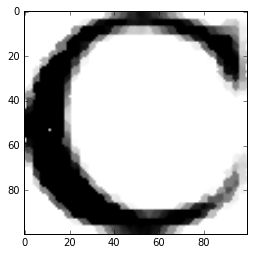

In [45]:
plt.imshow(PIL.Image.fromarray(a.astype(np.uint8)), cmap='Greys')